# Experiment: Study the phase dependence of SX varying the thermalization time

Thomas Alexander on Slack hypothesizes that the phase dependence of the polar rotation angle of the SX gate comes from an imperfect qubit initialization.  
A long thermalization time should ensure that the qubit starts at $|0\rangle$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, IBMQ
from qiskit.circuit import Gate, Parameter
from qiskit.circuit.barrier import Barrier
from qiskit import schedule as build_schedule
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging

from pulse_experiment_utils import *

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
backend = provider.get_backend('ibmq_santiago')
test_qubit = 1 # From phi_dependence_survey

config = backend.configuration()

In [3]:
config.dynamic_reprate_enabled

True

In [4]:
print('Rep delay:', config.rep_delay_range)
print('Default delay:', config.default_rep_delay)

Rep delay: [0.0, 0.0005]
Default delay: 0.00025


## First make sure that a long thermalization does indeed lead to the qubit starting at $|0\rangle$

In [5]:
def reset_measure(nreset):
    circuit = QuantumCircuit(1, 1)
    for _ in range(nreset):
        circuit.reset(0)
    circuit.measure(0, 0)
    return circuit

def x_measure():
    circuit = QuantumCircuit(1, 1)
    circuit.x(0)
    circuit.measure(0, 0)
    return circuit
    
circuits = []
circuits.append(reset_measure(5))
for nreset in [0, 1, 3, 5]:
    circuits.append(x_measure())
    circuits.append(reset_measure(nreset))
    
circuits = transpile(circuits, backend=backend, initial_layout=[test_qubit], optimization_level=0)

for circuit in circuits:
    print(circuit)

                                           
ancilla_0 -> 0 ────────────────────────────
                                        ┌─┐
      q_0 -> 1 ─|0>──|0>──|0>──|0>──|0>─┤M├
                                        └╥┘
ancilla_1 -> 2 ──────────────────────────╫─
                                         ║ 
ancilla_2 -> 3 ──────────────────────────╫─
                                         ║ 
ancilla_3 -> 4 ──────────────────────────╫─
                                         ║ 
          c: 1/══════════════════════════╩═
                                         0 
                       
ancilla_0 -> 0 ────────
               ┌───┐┌─┐
      q_0 -> 1 ┤ X ├┤M├
               └───┘└╥┘
ancilla_1 -> 2 ──────╫─
                     ║ 
ancilla_2 -> 3 ──────╫─
                     ║ 
ancilla_3 -> 4 ──────╫─
                     ║ 
          c: 1/══════╩═
                     0 
                  
ancilla_0 -> 0 ───
               ┌─┐
      q_0 -> 1 ┤M├
               └╥┘
ancilla_1 -> 2 ─╫─
  

In [6]:
rep_delays = np.linspace(0., 0.0005, 6)

jobs = []
for rep_delay in rep_delays:
    jobs.append(backend.run(circuits, init_qubits=False, rep_delay=rep_delay))
    
for job in jobs:
    job_monitor(job)

Job Status: job incurred error     
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [7]:
jobs[-1].result().get_counts()

[{'0': 1017, '1': 7},
 {'0': 55, '1': 969},
 {'0': 1019, '1': 5},
 {'0': 45, '1': 979},
 {'0': 1020, '1': 4},
 {'0': 53, '1': 971},
 {'0': 1022, '1': 2},
 {'0': 49, '1': 975},
 {'0': 1017, '1': 7}]

In [8]:
reset_counts = np.empty((5, 5), dtype=np.float)
x_counts = np.empty((5, 4), dtype=np.float)

for ijob, job in enumerate(jobs[1:]):
    counts = job.result().get_counts()
    reset_counts[ijob] = np.array([counts[i].get('0', 0) for i in range(0, 10, 2)])
    x_counts[ijob] = np.array([counts[i].get('0', 0) for i in range(1, 9, 2)])

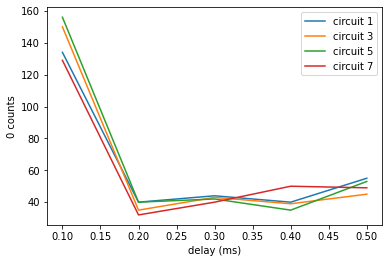

In [18]:
plt.plot(rep_delays[1:] * 1.e3, x_counts, label=['circuit {}'.format(i) for i in range(1, 9, 2)])
plt.xlabel('delay (ms)')
plt.ylabel('0 counts')
plt.legend()

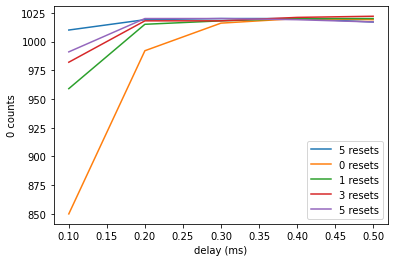

In [19]:
plt.plot(rep_delays[1:] * 1.e3, reset_counts, label=['{} resets'.format(n) for n in [5, 0, 1, 3, 5]])
plt.xlabel('delay (ms)')
plt.ylabel('0 counts')
plt.legend()

## Number of resets and delay determined. Now run the actual experiment

Will go with 3 resets + 0.5 ms delay

In [29]:
phi = Parameter('phi')
phi_values = np.linspace(-np.pi, np.pi, 32)

def phase_scan_circuit(nreset):
    circuit = QuantumCircuit(1, 1)
    for _ in range(nreset):
        circuit.reset(0)
    circuit.rz(phi, 0)
    circuit.sx(0)
    circuit.measure(0, 0)
    return circuit
    
exp_circuit = phase_scan_circuit(3)
ctrl_circuit = phase_scan_circuit(0)

exp_circuits = [exp_circuit.assign_parameters({phi: phi_value}) for phi_value in phi_values]
exp_circuits = transpile(exp_circuits, backend=backend, initial_layout=[test_qubit], optimization_level=0)

ctrl_circuits = [ctrl_circuit.assign_parameters({phi: phi_value}) for phi_value in phi_values]
ctrl_circuits = transpile(ctrl_circuits, backend=backend, initial_layout=[test_qubit], optimization_level=0)

print(exp_circuits[3].draw(idle_wires=False))
print(ctrl_circuits[5].draw(idle_wires=False))

                        ┌───────────────────────┐┌────┐┌─┐
q_0 -> 1 ─|0>──|0>──|0>─┤ RZ(-2.53354246257241) ├┤ √X ├┤M├
                        └───────────────────────┘└────┘└╥┘
    c: 1/═══════════════════════════════════════════════╩═
                                                        0 
         ┌───────────────────────┐┌────┐┌─┐
q_0 -> 1 ┤ RZ(-2.12817566856083) ├┤ √X ├┤M├
         └───────────────────────┘└────┘└╥┘
    c: 1/════════════════════════════════╩═
                                         0 


In [32]:
exp_job = backend.run(exp_circuits, init_qubits=False, rep_delay=0.0005, shots=8192)
ctrl_job = backend.run(ctrl_circuits, shots=8192)

job_monitor(exp_job)
job_monitor(ctrl_job)

Job Status: job has successfully run
Job Status: job has successfully run


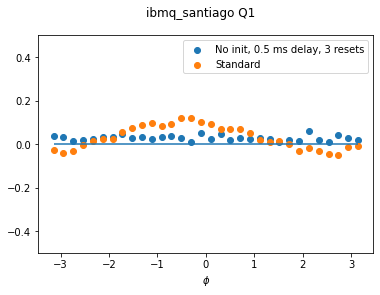

In [40]:
counts = exp_job.result().get_counts()
y = np.array([((c.get('0', 0) - c.get('1', 0)) / 8192) for c in counts])
plt.scatter(phi_values, y, label='No init, 0.5 ms delay, 3 resets')
counts = ctrl_job.result().get_counts()
y = np.array([((c.get('0', 0) - c.get('1', 0)) / 8192) for c in counts])
plt.scatter(phi_values, y, label='Standard')
plt.hlines([0], -np.pi, np.pi)
plt.xlabel('$\phi$')
plt.ylim(-0.5, 0.5)
plt.suptitle('ibmq_santiago Q1')
plt.legend()